In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import os
import pickle
from glob import glob
import logging

import umap
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, GridSearchCV
from gensim.models import Word2Vec, Doc2Vec
# import tensorflow as tf

from Doc2Vec import Doc2Vec, GensimSVMSklearn
from Constants import SENTIMENTS, TRAINING_DATA, TESTING_DATA

/Users/alanclark/.pyenv/versions/3.8.11/envs/mlmi13/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

# Data Load

In [5]:
#####################
# Original review data
#####################
og_base_dir = os.path.join('data', 'reviews')
og_pos_dir = os.path.join(og_base_dir, 'POS')
og_neg_dir = os.path.join(og_base_dir, 'NEG')

og_training_pos_files = glob(os.path.join(og_pos_dir, 'cv[0-8]*.txt'))
og_training_neg_files = glob(os.path.join(og_neg_dir, 'cv[0-8]*.txt'))

og_testing_pos_files = glob(os.path.join(og_pos_dir, 'cv9*.txt'))
og_testing_neg_files = glob(os.path.join(og_neg_dir, 'cv9*.txt'))

og_y_train = np.array([
    *[SENTIMENTS.pos.review_label]*len(og_training_pos_files),
    *[SENTIMENTS.neg.review_label]*len(og_training_neg_files)
])
og_y_test = np.array([
    *[SENTIMENTS.pos.review_label]*len(og_testing_pos_files),
    *[SENTIMENTS.neg.review_label]*len(og_testing_neg_files)
])

d2v_training_files = [
    *og_training_pos_files,
    *og_training_neg_files,
    *og_testing_pos_files,
    *og_testing_neg_files
]
d2v_testing_files = []

# gensim_sklearn = GensimSVMSklearn(
#     d2v_training_files=d2v_training_files,
#     d2v_epochs=100,
#     d2v_infer_epochs=50,
#     d2v_min_count=5,
#     d2v_vector_size=50,
#     d2v_window=5,
#     d2v_dm=0,
#     d2v_dm_concat=0,
#     d2v_dbow_words=1
# )

In [6]:
###########
# IMDB data
###########
imdb_base_dir = 'imdb'
imdb_pos_dir = 'pos'
imdb_neg_dir = 'neg'
imdb_unsup_dir = 'unsup'

imdb_train_dir = os.path.join(imdb_base_dir, 'train')
imdb_train_pos_dir = os.path.join(imdb_train_dir, imdb_pos_dir)
imdb_train_neg_dir = os.path.join(imdb_train_dir, imdb_neg_dir)

imdb_test_dir = os.path.join(imdb_base_dir, 'test')
imdb_test_pos_dir = os.path.join(imdb_test_dir, imdb_pos_dir)
imdb_test_neg_dir = os.path.join(imdb_test_dir, imdb_neg_dir)

imdb_training_pos_files = glob(os.path.join(imdb_train_pos_dir, '*.txt'))
imdb_training_neg_files = glob(os.path.join(imdb_train_neg_dir, '*.txt'))

imdb_testing_pos_files = glob(os.path.join(imdb_test_pos_dir, '*.txt'))
imdb_testing_neg_files = glob(os.path.join(imdb_test_neg_dir, '*.txt'))

imdb_unsup_files = glob(os.path.join(imdb_base_dir, imdb_train_dir, imdb_unsup_dir, '*.txt'))

imdb_y_train = np.array([
    *[SENTIMENTS.pos.review_label]*len(imdb_training_pos_files),
    *[SENTIMENTS.neg.review_label]*len(imdb_training_neg_files)
])
imdb_y_test = np.array([
    *[SENTIMENTS.pos.review_label]*len(imdb_testing_pos_files),
    *[SENTIMENTS.neg.review_label]*len(imdb_testing_neg_files)
])

# d2v_training_files = [
#     *imdb_training_pos_files,
#     *imdb_training_neg_files,
#     *imdb_testing_pos_files,
#     *imdb_testing_neg_files,
#     *imdb_unsup_files
# ]
# d2v_testing_files = []

# Sklearn Pipeline with Gensim

Learns embeddings and then trains a SVM classifier.

## Load Previous Results

In [7]:
# with open('d2v_models/d2v_imdb_1.pkl', 'rb') as f:
#     gensim_sklearn = pickle.load(f)

## Train New

In [8]:
gensim_sklearn = GensimSVMSklearn(
    d2v_training_files=d2v_training_files,
    d2v_epochs=100,
    d2v_infer_epochs=50,
    d2v_min_count=5,
    d2v_vector_size=50,
    d2v_window=5,
    d2v_dm=0,
    d2v_dm_concat=0,
    d2v_dbow_words=1
)

In [9]:
gensim_sklearn.train([*og_training_pos_files, *og_training_neg_files], og_y_train)

2021-12-03 14:26:14,609 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec(dbow+w,d50,n5,w5,mc5,s0.001,t4)', 'datetime': '2021-12-03T14:26:14.609481', 'gensim': '4.1.2', 'python': '3.8.11 (default, Aug  8 2021, 15:14:31) \n[Clang 12.0.5 (clang-1205.0.22.9)]', 'platform': 'macOS-12.0.1-x86_64-i386-64bit', 'event': 'created'}
2021-12-03 14:26:14,612 : INFO : collecting all words and their counts
2021-12-03 14:26:14,613 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-12-03 14:26:15,088 : INFO : collected 39564 word types and 2000 unique tags from a corpus of 2000 examples and 1253403 words
2021-12-03 14:26:15,090 : INFO : Creating a fresh vocabulary
2021-12-03 14:26:15,285 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=5 retains 14622 unique words (36.95784046102517%% of original 39564, drops 24942)', 'datetime': '2021-12-03T14:26:15.285476', 'gensim': '4.1.2', 'python': '3.8.11 (default, Aug  8 2021, 15:14:31) \n[Clang 12.0.5 (clang-1

[Pipeline] ........... (step 1 of 2) Processing doc2vec, total= 6.9min
[Pipeline] ............... (step 2 of 2) Processing svc, total=   0.1s


In [10]:
gensim_sklearn.test([*og_training_pos_files, *og_training_neg_files], og_y_train)

In [ ]:
gensim_sklearn.test([*og_testing_pos_files, *og_testing_neg_files], og_y_test)

0.855


## Save Model

Save the Gensim sklearn pickle

In [12]:
# with open('d2v_models/d2v_imdb_1.pkl', 'wb') as f:
#     pickle.dump(gensim_sklearn, f)

In [13]:
# gensim_sklearn.pipeline.named_steps['doc2vec'].model.save('d2v_models/d2v_imdb_1.gensim')

2021-12-03 13:57:11,061 : INFO : Doc2Vec lifecycle event {'fname_or_handle': 'd2v_models/d2v_imdb_1.gensim', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-12-03T13:57:11.061411', 'gensim': '4.1.2', 'python': '3.8.11 (default, Aug  8 2021, 15:14:31) \n[Clang 12.0.5 (clang-1205.0.22.9)]', 'platform': 'macOS-12.0.1-x86_64-i386-64bit', 'event': 'saving'}
2021-12-03 13:57:11,063 : INFO : not storing attribute cum_table
2021-12-03 13:57:11,113 : INFO : saved d2v_models/d2v_imdb_1.gensim


## Cross Validation

In [16]:
# gensim_sklearn.cross_validate([*training_pos_files, *training_neg_files], y_train, folds=10)

## Grid Search

In [48]:
# gs_params = {
#     'doc2vec__epochs': (100,),
#     'doc2vec__infer_epochs': (50,),
#     'doc2vec__vector_size': (50,100,200), 
#     'doc2vec__dm': (0,1),
#     'doc2vec__dm_concat': (0,1),
#     'doc2vec__dbow_words': (1,),
#     'doc2vec__window': (5,10,15),
#     'doc2vec__min_count': (5,)
# }
# gensim_sklearn = GensimSVMSklearn(d2v_training_files=d2v_training_files)
# gensim_sklearn.grid_search([*training_pos_files, *training_neg_files], y_train, gs_params)

In [ ]:
# pd.DataFrame(gensim_sklearn.gs.cv_results_).to_json()

In [ ]:
# gensim_sklearn.gs.best_params_

In [ ]:
# gensim_sklearn.gs.best_score_

In [ ]:
# gensim_sklearn.pipeline.named_steps['doc2vec'].model.save('doc2vec_model.gensim')

Open a pre-saved CV model and save the results to a csv

In [ ]:
# with open('d2v_gs/d2v_gs_sc_sc_epoch_vs_search.pkl', 'rb') as f:
#     d2v_gs = pickle.load(f)

In [ ]:
# pd.DataFrame(d2v_gs.gs.cv_results_).to_csv('d2v_gs/d2v_gs_sc_sc_epoch_vs_search_results.csv')

# Generate Embeddings

In [14]:
og_training_pos_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_training_pos_files)
og_training_neg_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_training_neg_files)
og_testing_pos_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_testing_pos_files)
og_testing_neg_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(og_testing_neg_files)

In [15]:
og_X_train = np.vstack((og_training_pos_embeddings, og_training_neg_embeddings))
og_X_test = np.vstack((og_testing_pos_embeddings, og_testing_neg_embeddings))
og_X_train.shape, og_X_test.shape

((1800, 50), (200, 50))

In [16]:
imdb_training_pos_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(imdb_training_pos_files)
imdb_training_neg_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(imdb_training_neg_files)
imdb_testing_pos_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(imdb_testing_pos_files)
imdb_testing_neg_embeddings = gensim_sklearn.pipeline.named_steps['doc2vec'].transform(imdb_testing_neg_files)

In [17]:
imdb_X_train = np.vstack((imdb_training_pos_embeddings, imdb_training_neg_embeddings))
imdb_X_test = np.vstack((imdb_testing_pos_embeddings, imdb_testing_neg_embeddings))
imdb_X_train.shape, imdb_X_test.shape

((25000, 50), (25000, 50))

# SVC

## OG Data

In [18]:
logger.info('Training SVM with embeddings')
svm = SVC()
svm.fit(og_X_train, og_y_train)

2021-12-03 14:08:45,186 : INFO : Training SVM with embeddings


SVC()

In [19]:
logger.info('Testing SVM with embeddings')
# svm.cross_validate(og_X_train, og_y_train, folds=10)
og_train_predict = svm.predict(og_X_train)
og_test_predict = svm.predict(og_X_test)

2021-12-03 14:08:45,341 : INFO : Testing SVM with embeddings


In [20]:
svm.score(og_X_train, og_y_train), svm.score(og_X_test, og_y_test)

(0.9322222222222222, 0.84)

In [21]:
cross_val_score(svm, og_X_train, og_y_train, cv=10)

array([0.83888889, 0.81111111, 0.84444444, 0.82777778, 0.81666667,
       0.86666667, 0.87777778, 0.84444444, 0.87777778, 0.86111111])

In [22]:
svm_gs_params = {
    "C": np.arange(0.2, 10.2, 0.4),
    "kernel": ["linear", "poly", "rbf", "sigmoid"]
}
grid_search = GridSearchCV(SVC(), svm_gs_params, n_jobs=-1, cv=10)
grid_search.fit(og_X_train, og_y_train)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([0.2, 0.6, 1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ,
       5.4, 5.8, 6.2, 6.6, 7. , 7.4, 7.8, 8.2, 8.6, 9. , 9.4, 9.8]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [23]:
grid_search.best_score_, grid_search.best_params_

(0.8483333333333333, {'C': 1.8000000000000003, 'kernel': 'rbf'})

In [24]:
svm = SVC(**grid_search.best_params_)
svm.fit(og_X_train, og_y_train)
svm.score(og_X_train, og_y_train), svm.score(og_X_test, og_y_test)

(0.9594444444444444, 0.84)

## IMDB Data

In [25]:
logger.info('Training SVM with embeddings')
svm = SVC()
svm.fit(imdb_X_train, imdb_y_train)

2021-12-03 14:09:11,378 : INFO : Training SVM with embeddings


SVC()

In [26]:
logger.info('Testing SVM with embeddings')
imdb_train_predict = svm.predict(imdb_X_train)
imdb_test_predict = svm.predict(imdb_X_test)

2021-12-03 14:09:29,895 : INFO : Testing SVM with embeddings


In [27]:
svm.score(imdb_X_train, imdb_y_train), svm.score(imdb_X_test, imdb_y_test)

(0.93652, 0.86956)

In [28]:
cross_val_score(svm, imdb_X_train, imdb_y_train, cv=10)

array([0.882 , 0.8944, 0.8952, 0.9072, 0.9096, 0.9076, 0.904 , 0.9108,
       0.9172, 0.9028])

## Gensim Learnt Word Embeddings

In [29]:
gensim_vectors = np.asarray(gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.vectors)
gensim_labels = np.asarray(gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.index_to_key)
gensim_vectors.shape, gensim_labels.shape

((39191, 50), (39191,))

In [30]:
gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('wonderful')

[('fantastic', 0.9039798974990845),
 ('fabulous', 0.8897414803504944),
 ('marvelous', 0.880354106426239),
 ('great', 0.8698416352272034),
 ('terrific', 0.8660570979118347),
 ('splendid', 0.8633565902709961),
 ('superb', 0.8581591248512268),
 ('excellent', 0.849800705909729),
 ('fine', 0.8446365594863892),
 ('amazing', 0.8417888283729553)]

Use this to generate embeddings to use in Tensorflow

In [ ]:
# gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.save_word2vec_format('gensim_word_embeddings.gensim')

In [ ]:
# !python -m gensim.scripts.word2vec2tensor -i gensim_word_embeddings.gensim -o gensim_word_embeddings.tsv

# Existing Word Embeddings

In [108]:
# wiki_sg = Doc2Vec.load(os.path.join('wiki_sg', 'word2vec.bin'))
# wiki_sg

# Lexicon Data

In [39]:
lexicon_dict = {}
with open('data/sent_lexicon', 'r') as f:
    for line in f:
        word = line.split()[2].split("=")[1]
        polarity = line.split()[5].split("=")[1]
        magnitude = line.split()[0].split("=")[1]
        lexicon_dict[word] = [magnitude, polarity]
lexicon_pos_words = [w for w,t in lexicon_dict.items() if t[1] == 'positive' and t[0] == 'strongsubj' and w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]
lexicon_neg_words = [w for w,t in lexicon_dict.items() if t[1] == 'negative' and t[0] == 'strongsubj' and w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]
# lexicon_pos_words = [w for w,t in lexicon_dict.items() if t[1] == 'positive' and w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]
# lexicon_neg_words = [w for w,t in lexicon_dict.items() if t[1] == 'negative' and w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]

good_words = ['good', *[i[0] for i in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('good')]]
bad_words = ['bad', *[i[0] for i in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('bad')]]

wonderful_words = ['wonderful', *[i[0] for i in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('wonderful')]]
awful_words = ['awful', *[i[0] for i in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar('awful')]]

In [40]:
# General positive and negative indices
pos_inds = np.where(np.isin(gensim_labels,lexicon_pos_words))
neg_inds = np.where(np.isin(gensim_labels,lexicon_neg_words))

# Weakly positive and negative words
good_inds = np.where(np.isin(gensim_labels, good_words))[0]
bad_inds = np.where(np.isin(gensim_labels, bad_words))[0]

# Strongly positive and negative words
wonderful_inds = np.where(np.isin(gensim_labels, wonderful_words))[0]
awful_inds = np.where(np.isin(gensim_labels, awful_words))[0]

In [41]:
lexicon_pos_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in lexicon_pos_words])
lexicon_neg_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in lexicon_neg_words])

good_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in good_words])
bad_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in bad_words])

wonderful_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in wonderful_words])
awful_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in awful_words])

# Visualisations

## Gensim Instructions

In [42]:
# def reduce_dimensions(model):
#     num_dimensions = 2  # final num dimensions (2D, 3D, etc)

#     # extract the words & their vectors, as numpy arrays
#     vectors = np.asarray(model.wv.vectors)
#     labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

#     # reduce using t-SNE
#     tsne = TSNE(n_components=num_dimensions, random_state=0)
#     vectors = tsne.fit_transform(vectors)

#     x_vals = [v[0] for v in vectors]
#     y_vals = [v[1] for v in vectors]
#     return x_vals, y_vals, labels, tsne


# x_vals, y_vals, labels, tsne = reduce_dimensions(gensim_sklearn.pipeline.named_steps['doc2vec'].model)
# x_vals = np.array(x_vals)
# y_vals = np.array(y_vals)

In [43]:
def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

## TSNE

In [61]:
imdb_embeddings = np.vstack((imdb_X_train, imdb_X_test))
imdb_labels = np.hstack((imdb_y_train, imdb_y_test))

tsne_embeddings = np.vstack((gensim_vectors, imdb_embeddings))
tsne_labels = np.hstack((gensim_labels, imdb_labels))

tsne_reviews = np.hstack((np.zeros_like(gensim_labels), np.array(imdb_training_pos_files), np.array(imdb_training_neg_files), np.array(imdb_testing_pos_files), np.array(imdb_testing_neg_files)))

In [62]:
num_tsne_dimensions = 2
tsne = TSNE(n_components=num_tsne_dimensions, random_state=0, n_jobs=-1, verbose=5)
tsne_vectors = tsne.fit_transform(tsne_embeddings)

/Users/alanclark/.pyenv/versions/3.8.11/envs/mlmi13/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/alanclark/.pyenv/versions/3.8.11/envs/mlmi13/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 89191 samples in 0.004s...


In [ ]:
tsne_vectors.shape, tsne_labels.shape

((87330, 2), (87330,))

In [19]:
# plot_with_plotly(tsne_vectors[:,0], tsne_vectors[:,1], labels)

In [20]:
# plot_with_matplotlib(tsne_vectors[:,0], tsne_vectors[:,1], labels)

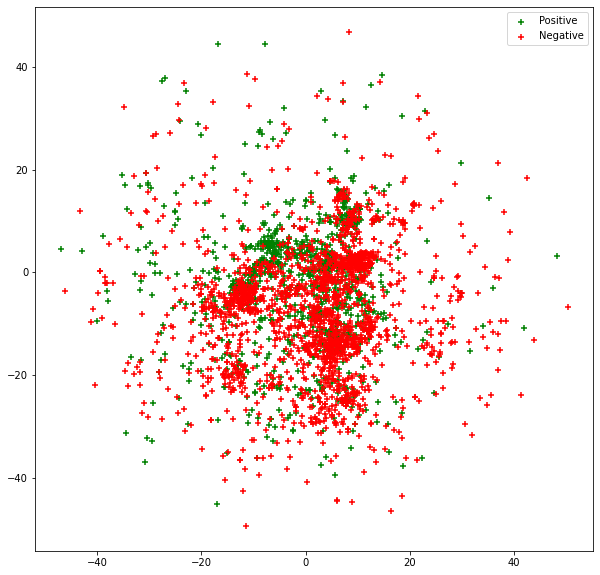

In [223]:
fig, ax = plt.subplots(1, figsize=(10,10))
plt.scatter(tsne_vectors[pos_inds,0], tsne_vectors[pos_inds,1], marker='+', c='g', label='Positive')
plt.scatter(tsne_vectors[neg_inds,0], tsne_vectors[neg_inds,1], marker='+', c='r', label='Negative')
plt.legend()

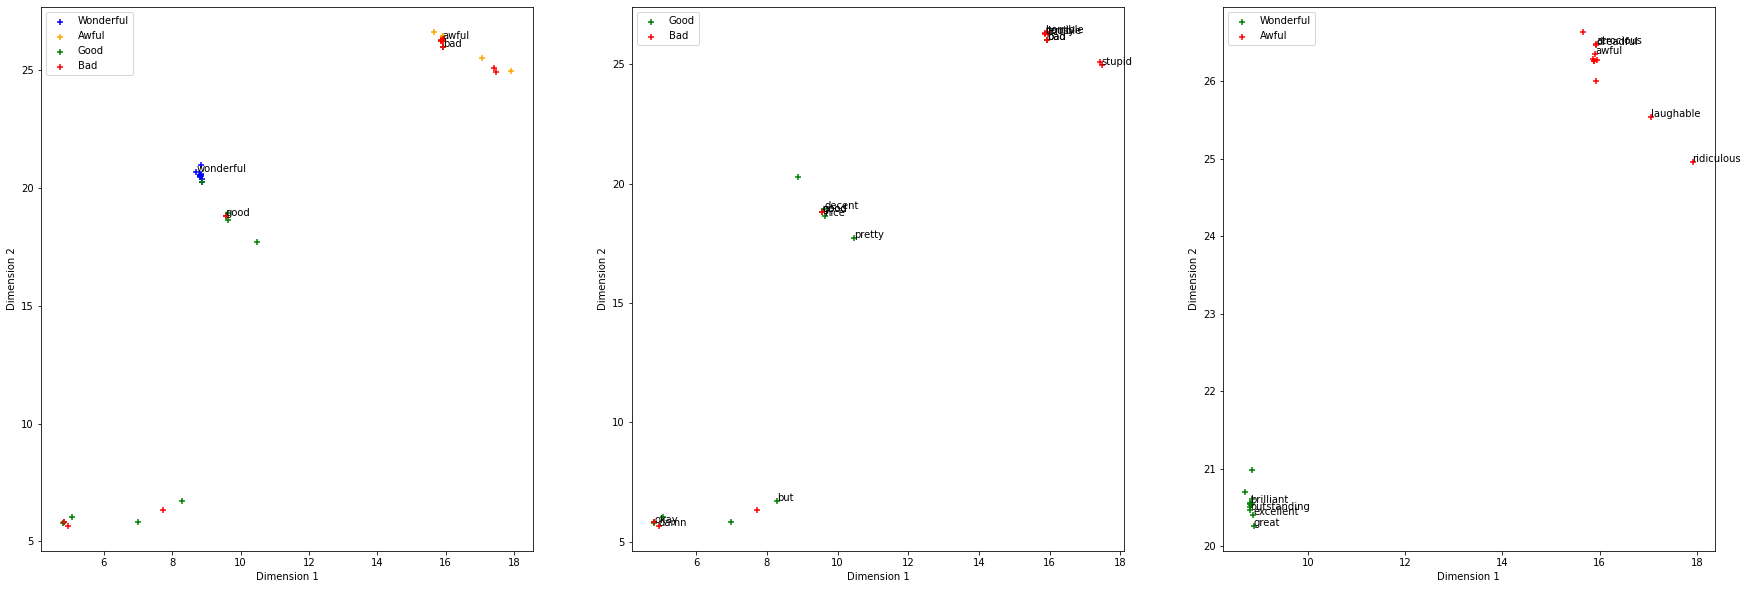

In [224]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

ax[0].scatter(x_vals[wonderful_inds], y_vals[wonderful_inds], marker='+', c='b', label='Wonderful')
ax[0].scatter(x_vals[awful_inds], y_vals[awful_inds], marker='+', c='orange', label='Awful')
ax[0].scatter(x_vals[good_inds], y_vals[good_inds], marker='+', c='g', label='Good')
ax[0].scatter(x_vals[bad_inds], y_vals[bad_inds], marker='+', c='r', label='Bad')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[0].legend(loc='upper left')
for w in ['wonderful', 'awful', 'good', 'bad']:
    label_ind = np.where(labels == w)[0]
    ax[0].annotate(labels[label_ind][0], (x_vals[label_ind], y_vals[label_ind]))

ax[1].scatter(x_vals[good_inds], y_vals[good_inds], marker='+', c='g', label='Good')
ax[1].scatter(x_vals[bad_inds], y_vals[bad_inds], marker='+', c='r', label='Bad')
for i in good_inds:
    if not i % 2:
        continue
    ax[1].annotate(labels[i], (x_vals[i], y_vals[i]))
for i in bad_inds:
    if not i % 2:
        continue
    ax[1].annotate(labels[i], (x_vals[i], y_vals[i]))
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[1].legend(loc='upper left')

ax[2].scatter(x_vals[wonderful_inds], y_vals[wonderful_inds], marker='+', c='g', label='Wonderful')
ax[2].scatter(x_vals[awful_inds], y_vals[awful_inds], marker='+', c='r', label='Awful')
for i in wonderful_inds:
    if i % 2:
        continue
    ax[2].annotate(labels[i], (x_vals[i], y_vals[i]))
for i in awful_inds:
    if i % 2:
        continue
    ax[2].annotate(labels[i], (x_vals[i], y_vals[i]))
ax[2].set_xlabel('Dimension 1')
ax[2].set_ylabel('Dimension 2')
ax[2].legend(loc='upper left')

In [236]:
tsne_imdb_review = 'imdb/train/pos/0_9.txt'
np.where(tsne_reviews == tsne_imdb_review)

(array([40760, 65760]),)

## PCA

In [55]:
pca_embeddings = gensim_vectors
# pca_embeddings = np.vstack((lexicon_pos_word_embeddings, lexicon_neg_word_embeddings))

pca_2 = PCA(n_components=2)
pca_embeds_2d = pca_2.fit(pca_embeddings)

pca_3 = PCA(n_components=3)
pca_embeds_3d = pca_3.fit(pca_embeddings)

pca_embeds_2d.explained_variance_ratio_, pca_embeds_3d.explained_variance_ratio_

(array([0.046034  , 0.03767783], dtype=float32),
 array([0.04603507, 0.03766982, 0.03489955], dtype=float32))

In [56]:
words_pca = pca_embeds_2d.transform(pca_embeddings)

In [57]:
lexicon_pos_words_pca = pca_embeds_2d.transform(lexicon_pos_word_embeddings)
lexicon_neg_words_pca = pca_embeds_2d.transform(lexicon_neg_word_embeddings)

good_words_pca = pca_embeds_2d.transform(good_word_embeddings)
bad_words_pca = pca_embeds_2d.transform(bad_word_embeddings)

wonderful_words_pca = pca_embeds_2d.transform(wonderful_word_embeddings)
awful_words_pca = pca_embeds_2d.transform(awful_word_embeddings)

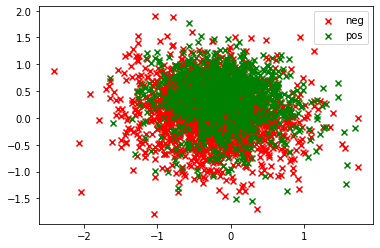

In [58]:
for embed_tuple in [('neg', lexicon_neg_words_pca), ('pos', lexicon_pos_words_pca)]:
    label, embeds = embed_tuple
    plt.scatter(embeds[:,0], embeds[:,1], marker='x', label=label, c='green' if label == 'pos' else 'red')
plt.legend()

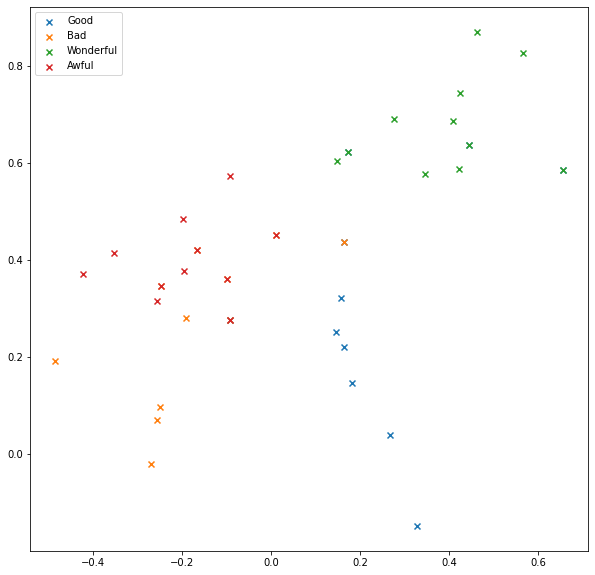

In [59]:
fig, ax = plt.subplots(1, figsize=(10,10))
for embed_tuple in [('Good', good_words_pca), ('Bad', bad_words_pca), ('Wonderful', wonderful_words_pca), ('Awful', awful_words_pca)]:
    label, embeds = embed_tuple
    ax.scatter(embeds[:,0], embeds[:,1], marker='x', label=label)
ax.legend()

In [51]:
words_pca.shape

(39191, 2)

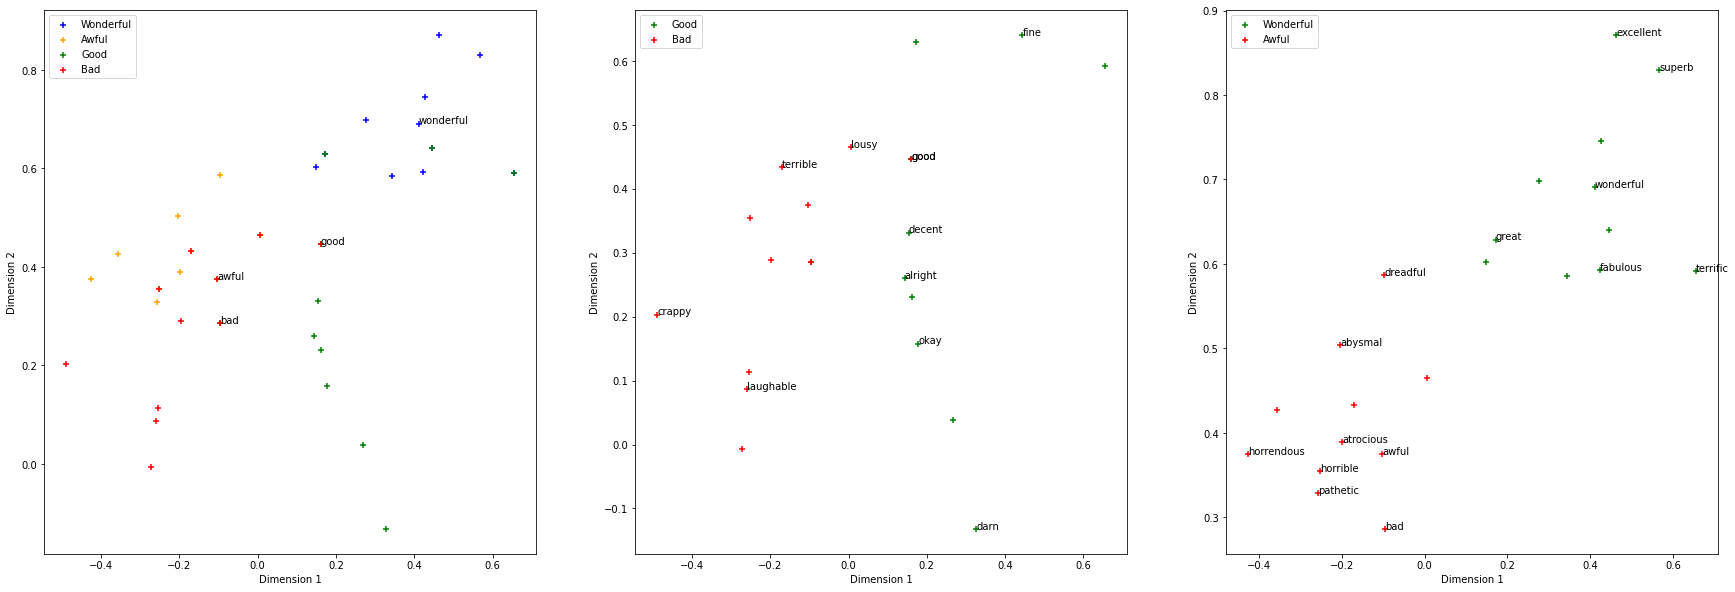

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

ax[0].scatter(wonderful_words_pca[:,0], wonderful_words_pca[:,1], marker='+', c='b', label='Wonderful')
ax[0].scatter(awful_words_pca[:,0], awful_words_pca[:,1], marker='+', c='orange', label='Awful')
ax[0].scatter(good_words_pca[:,0], good_words_pca[:,1], marker='+', c='g', label='Good')
ax[0].scatter(bad_words_pca[:,0], bad_words_pca[:,1], marker='+', c='r', label='Bad')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[0].legend(loc='upper left')
for w in ['wonderful', 'awful', 'good', 'bad']:
    label_ind = np.where(gensim_labels == w)[0]
    ax[0].annotate(gensim_labels[label_ind][0], (words_pca[label_ind,0], words_pca[label_ind,1]))

ax[1].scatter(good_words_pca[:,0], good_words_pca[:,1], marker='+', c='g', label='Good')
ax[1].scatter(bad_words_pca[:,0], bad_words_pca[:,1], marker='+', c='r', label='Bad')
for i in good_inds:
    if not i % 2:
        continue
    ax[1].annotate(gensim_labels[i], (words_pca[i,0], words_pca[i,1]))
for i in bad_inds:
    if not i % 2:
        continue
    ax[1].annotate(gensim_labels[i], (words_pca[i,0], words_pca[i,1]))
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[1].legend(loc='upper left')

ax[2].scatter(wonderful_words_pca[:,0], wonderful_words_pca[:,1], marker='+', c='g', label='Wonderful')
ax[2].scatter(awful_words_pca[:,0], awful_words_pca[:,1], marker='+', c='r', label='Awful')
for i in wonderful_inds:
    if i % 2:
        continue
    ax[2].annotate(gensim_labels[i], (words_pca[i,0], words_pca[i,1]))
for i in awful_inds:
    if i % 2:
        continue
    ax[2].annotate(gensim_labels[i], (words_pca[i,0], words_pca[i,1]))
ax[2].set_xlabel('Dimension 1')
ax[2].set_ylabel('Dimension 2')
ax[2].legend(loc='upper left')

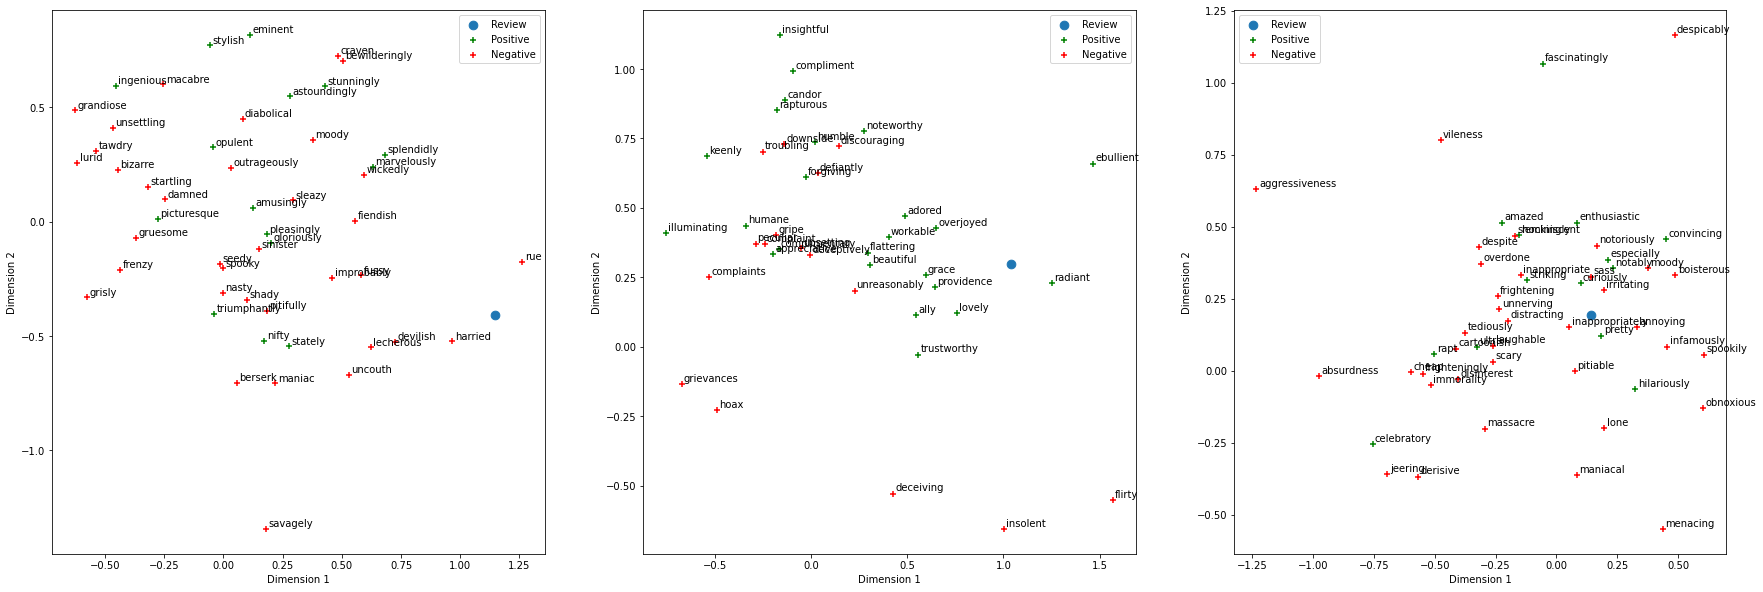

In [54]:
visualisation_review_inds = [1, 10, 100]
imdb_review_dir = imdb_train_pos_dir
# imdb_review_dir = imdb_train_neg_dir

fig, ax = plt.subplots(1, 3, figsize=(30,10))

for i, visualisation_review_ind in enumerate(visualisation_review_inds):
    review_embedding = gensim_sklearn.pipeline.named_steps['doc2vec'].transform([os.path.join(imdb_review_dir,gensim_sklearn.pipeline.named_steps['doc2vec'].train_corpus[visualisation_review_ind].tags[0])])
    review_embedding_pca = pca_embeds_2d.transform(review_embedding)

    with open(os.path.join(imdb_review_dir,gensim_sklearn.pipeline.named_steps['doc2vec'].train_corpus[visualisation_review_ind].tags[0])) as f:
        review_tokens = word_tokenize(f.readlines()[0])

    review_closest_words = [w[0] for w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv.most_similar(review_embedding, topn=1000) if w[0] in [*lexicon_pos_words, *lexicon_neg_words]][:50]
    # review_lexicon_tokens = [w for w in review_closest_words if w in [*lexicon_pos_words, *lexicon_neg_words]]
    review_lexicon_labels = np.array([lexicon_dict[t][1] for t in review_closest_words])
    review_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in review_closest_words])
    review_word_embeddings_pca = pca_embeds_2d.transform(review_word_embeddings)

    ax[i].scatter(review_embedding_pca[:,0], review_embedding_pca[:,1], s=75, label='Review')

    plt_colors = {'positive':'green', 'negative':'red', 'neutral':'blue', 'both':'yellow'}
    for j in plt_colors.items():
        j_ind = np.where(review_lexicon_labels == j[0])
        if np.any(j_ind):
            ax[i].scatter(review_word_embeddings_pca[j_ind,0], review_word_embeddings_pca[j_ind,1], marker='+', c=j[1], label=j[0].title())

    for j in range(review_word_embeddings_pca.shape[0]):
        ax[i].annotate(review_closest_words[j], (review_word_embeddings_pca[j,0]+0.01, review_word_embeddings_pca[j,1]+0.01))

    ax[i].set_xlabel('Dimension 1')
    ax[i].set_ylabel('Dimension 2')
    # ax[i].set_xlim(-1.25, 2)
    # ax[i].set_ylim(-1.25, 2)
    ax[i].legend()

In [148]:
# lexicon_pos_words_pca_3d = pca_embeds_3d.transform(np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in lexicon_pos_words if w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]))
# lexicon_neg_words_pca_3d = pca_embeds_3d.transform(np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in lexicon_neg_words if w in gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv]))

# lexicon_pos_words_pca_df = pd.DataFrame(lexicon_pos_words_pca_3d)
# lexicon_pos_words_pca_df['sentiment'] = 'pos'

# lexicon_neg_words_pca_df = pd.DataFrame(lexicon_neg_words_pca_3d)
# lexicon_neg_words_pca_df['sentiment'] = 'neg'

# lexicon_pca_df = pd.concat((lexicon_pos_words_pca_df, lexicon_neg_words_pca_df))
# lexicon_pca_df['size'] = 0.8

# px.scatter_3d(lexicon_pca_df, x=0, y=1, z=2, color='sentiment', size='size')

## UMAP

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(gensim_vectors)

In [ ]:
fig, ax = plt.subplots(1, figsize=(30,10))
ax.scatter(embedding[:,0], embedding[:,1])

### Pang et al words

In [ ]:
gensim_sklearn = GensimSVMSklearn(
    d2v_training_files=d2v_training_files,
    d2v_epochs=100,
    d2v_infer_epochs=50,
    d2v_min_count=5,
    d2v_vector_size=50,
    d2v_window=5,
    d2v_dm=0,
    d2v_dm_concat=0,
    d2v_dbow_words=1
)

In [ ]:
pang_positive_words = 'love wonderful best great superb still beautiful'.split()
pang_negative_words = 'bad worst stupid waste boring terrible awful'.split()

In [ ]:
pang_positive_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in pang_positive_words])
pang_negative_word_embeddings = np.array([gensim_sklearn.pipeline.named_steps['doc2vec'].model.wv[w] for w in pang_negative_words])
pang_positive_word_embeddings.shape, pang_negative_word_embeddings.shape

In [ ]:
pang_positive_word_pca = pca_2.transform(pang_positive_word_embeddings)
pang_negative_word_pca = pca_2.transform(pang_negative_word_embeddings)

In [ ]:
pos_doc_ind = 10
neg_doc_ind = 10
pos_doc_pca = pca_2.transform(training_pos_embeddings[pos_doc_ind,:][None,:])[0]
neg_doc_pca = pca_2.transform(training_neg_embeddings[neg_doc_ind,:][None,:])[0]

In [ ]:
plt.scatter(pang_positive_word_pca[:,0], pang_positive_word_pca[:,1], marker='x', label='pos')
plt.scatter(pang_negative_word_pca[:,0], pang_negative_word_pca[:,1], marker='x', label='neg')
plt.scatter(pos_doc_pca[0], pos_doc_pca[1], marker='x', label='pos_doc')
plt.scatter(neg_doc_pca[0], neg_doc_pca[1], marker='x', label='neg_doc')
plt.legend()
for word, (x,y) in zip([*pang_positive_words, *pang_negative_words], np.vstack((pang_positive_word_pca, pang_negative_word_pca))):
    plt.text(x+0.05, y+0.05, word)